# Blob Features

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/MIDS/DATASCI 281 Summer 2025/datasci281_final_project (github)'

/content/drive/MyDrive/MIDS/DATASCI 281 Summer 2025/datasci281_final_project (github)


## Imports

In [3]:
!pip install opencv-python
!pip install xgboost

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.feature import hog, blob_log, blob_dog, blob_doh, canny
from skimage import data, exposure
from utils import *
from skimage.filters import difference_of_gaussians
from skimage.filters import laplace
from skimage.filters import gaussian
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, rotate
from skimage.color import rgb2gray
from sklearn.metrics import mean_squared_error
from scipy import stats
from skimage.feature import hessian_matrix, hessian_matrix_det
from math import ceil
import ast
import re
from sklearn.preprocessing import LabelEncoder

## Load Training Data

In [5]:
np.random.seed(281)

In [6]:
# Setup Data Paths
cwd = os.getcwd()
data_path = os.path.join(cwd,'standardized_data')

In [7]:
training_path = os.path.join(data_path,'Training')

# Initialize Data Variables
X_train = []
Y_train = []
image_file_names = []
image_file_paths = []

# Load in Images and Labels
for label in os.listdir(training_path):
    if label == ".DS_Store":
        continue
    label_path = os.path.join(training_path,label)
    for image in os.listdir(label_path):
        image_file_names.append(image)
        image_path = os.path.join(label_path,image)
        image_file_paths.append(image_path)
        img_array = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
        X_train.append(img_array)
        Y_train.append(label)

# Shuffle Data for Randomization
indices = [i for i in range(0,len(X_train))]
shuffle_indices = np.random.permutation(indices)
X_train_shuffled = [X_train[i] for i in shuffle_indices]
Y_train_shuffled = [Y_train[i] for i in shuffle_indices]
image_file_names_shuffled = [image_file_names[i] for i in shuffle_indices]
image_file_paths_shuffled = [image_file_paths[i] for i in shuffle_indices]

Pick 10 random images across all 4 classes--glioma, meningioma, pituitary, notumor--to examine.

In [8]:
np.random.seed(1230)
# pick 10 random images: 2 glioma, 3 meningioma, 3 pituitary, and 2 notumor
glioma_indices = [i for i, label in enumerate(Y_train_shuffled) if label == 'glioma']
meningioma_indices = [i for i, label in enumerate(Y_train_shuffled) if label == 'meningioma']
pituitary_indices = [i for i, label in enumerate(Y_train_shuffled) if label == 'pituitary']
notumor_indices = [i for i, label in enumerate(Y_train_shuffled) if label == 'notumor']

glioma_sample_indices = np.random.choice(glioma_indices, 2, replace=False)
meningioma_sample_indices = np.random.choice(meningioma_indices, 3, replace=False)
pituitary_sample_indices = np.random.choice(pituitary_indices, 3, replace=False)
notumor_sample_indices = np.random.choice(notumor_indices, 2, replace=False)

random_indices = np.concatenate((glioma_sample_indices, meningioma_sample_indices, pituitary_sample_indices, notumor_sample_indices))

In [9]:
random_indices_file_names = [image_file_names_shuffled[i] for i in random_indices]
random_indices_file_names

['Tr-gl_0078.jpg',
 'Tr-gl_0565.jpg',
 'Tr-me_0696.jpg',
 'Tr-me_0820.jpg',
 'Tr-me_0444.jpg',
 'Tr-pi_0035.jpg',
 'Tr-pi_0289.jpg',
 'Tr-pi_1446.jpg',
 'Tr-no_1561.jpg',
 'Tr-no_0122.jpg']

## Load Testing Data

In [10]:
testing_path = os.path.join(data_path,'Testing')

# Initialize Data Variables
X_test = []
Y_test = []
test_image_file_names = []
test_image_file_paths = []

# Load in Images and Labels
for label in os.listdir(testing_path):
    if label == ".DS_Store":
        continue
    label_path = os.path.join(testing_path,label)
    for image in os.listdir(label_path):
        test_image_file_names.append(image)
        image_path = os.path.join(label_path,image)
        test_image_file_paths.append(image_path)
        img_array = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
        X_test.append(img_array)
        Y_test.append(label)

## I. Brightness/Contrast EDA
 Our goal is to perform blob detection on the individual brain MRI scans to identify structures that are possible tumors. Before we implement any kind of blob detection, we perform EDA to determine what preprocessing steps to implement so that blob detection can work effectively.

Plot the 10 randomly selected images.

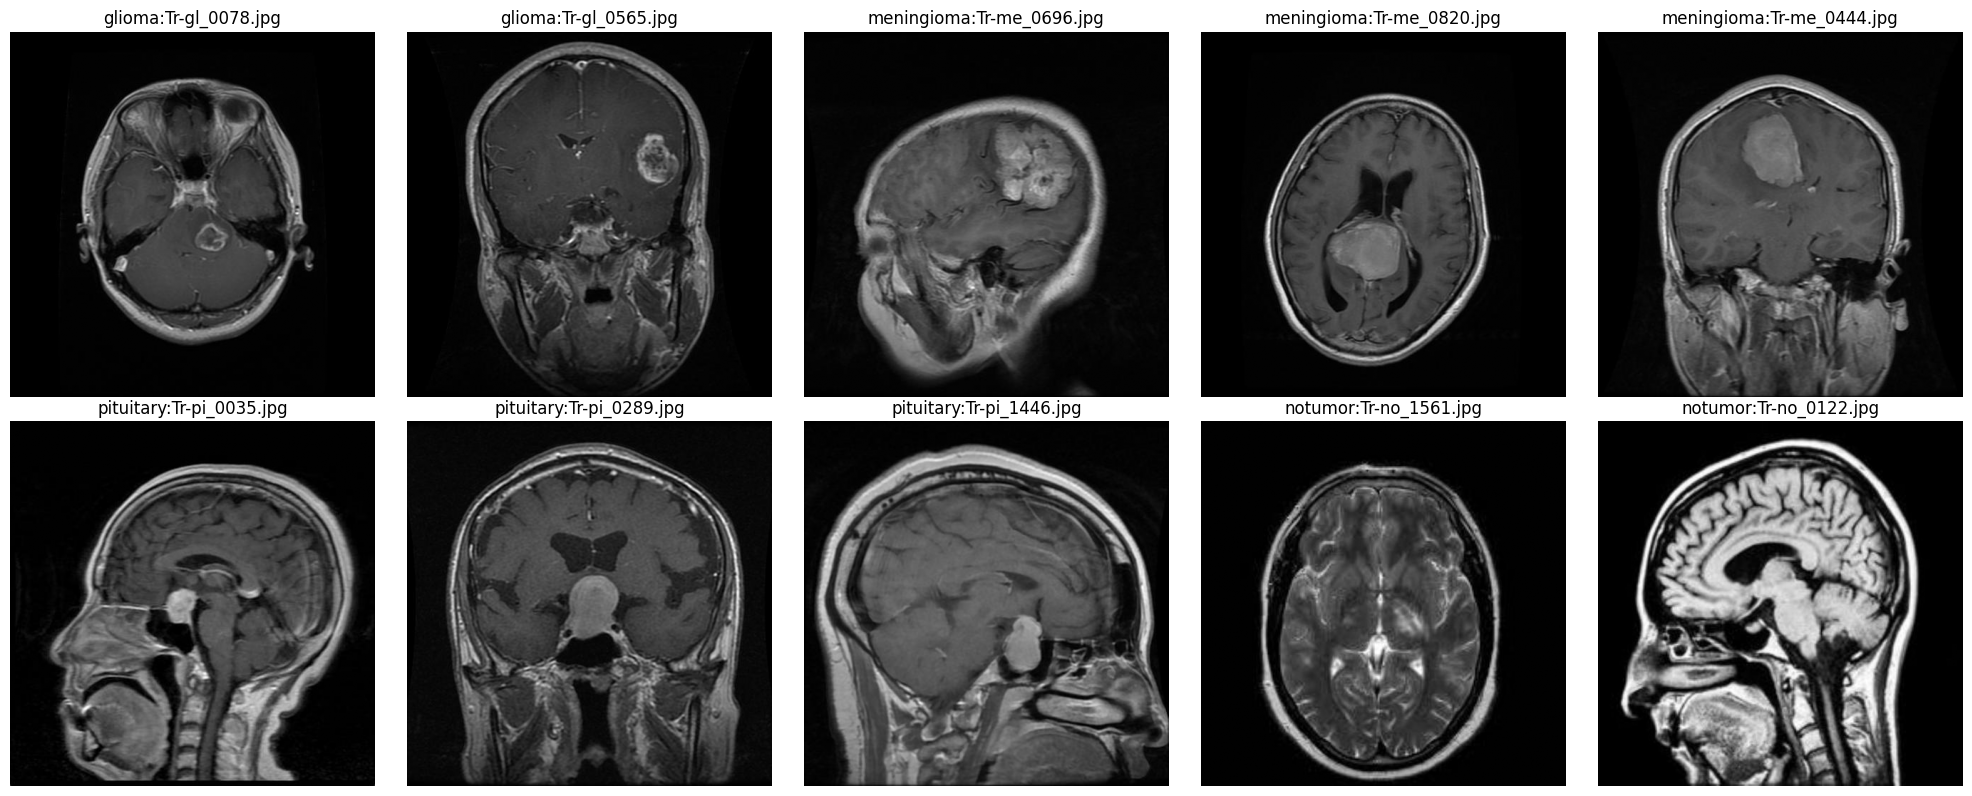

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    image = X_train_shuffled[idx]
    label = Y_train_shuffled[idx]
    ax = axes[i]
    ax.imshow(image, cmap='gray')
    ax.set_title(f"{label}:{random_indices_file_names[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

Plot the pixel intensity histograms of the 10 randomly selected images.

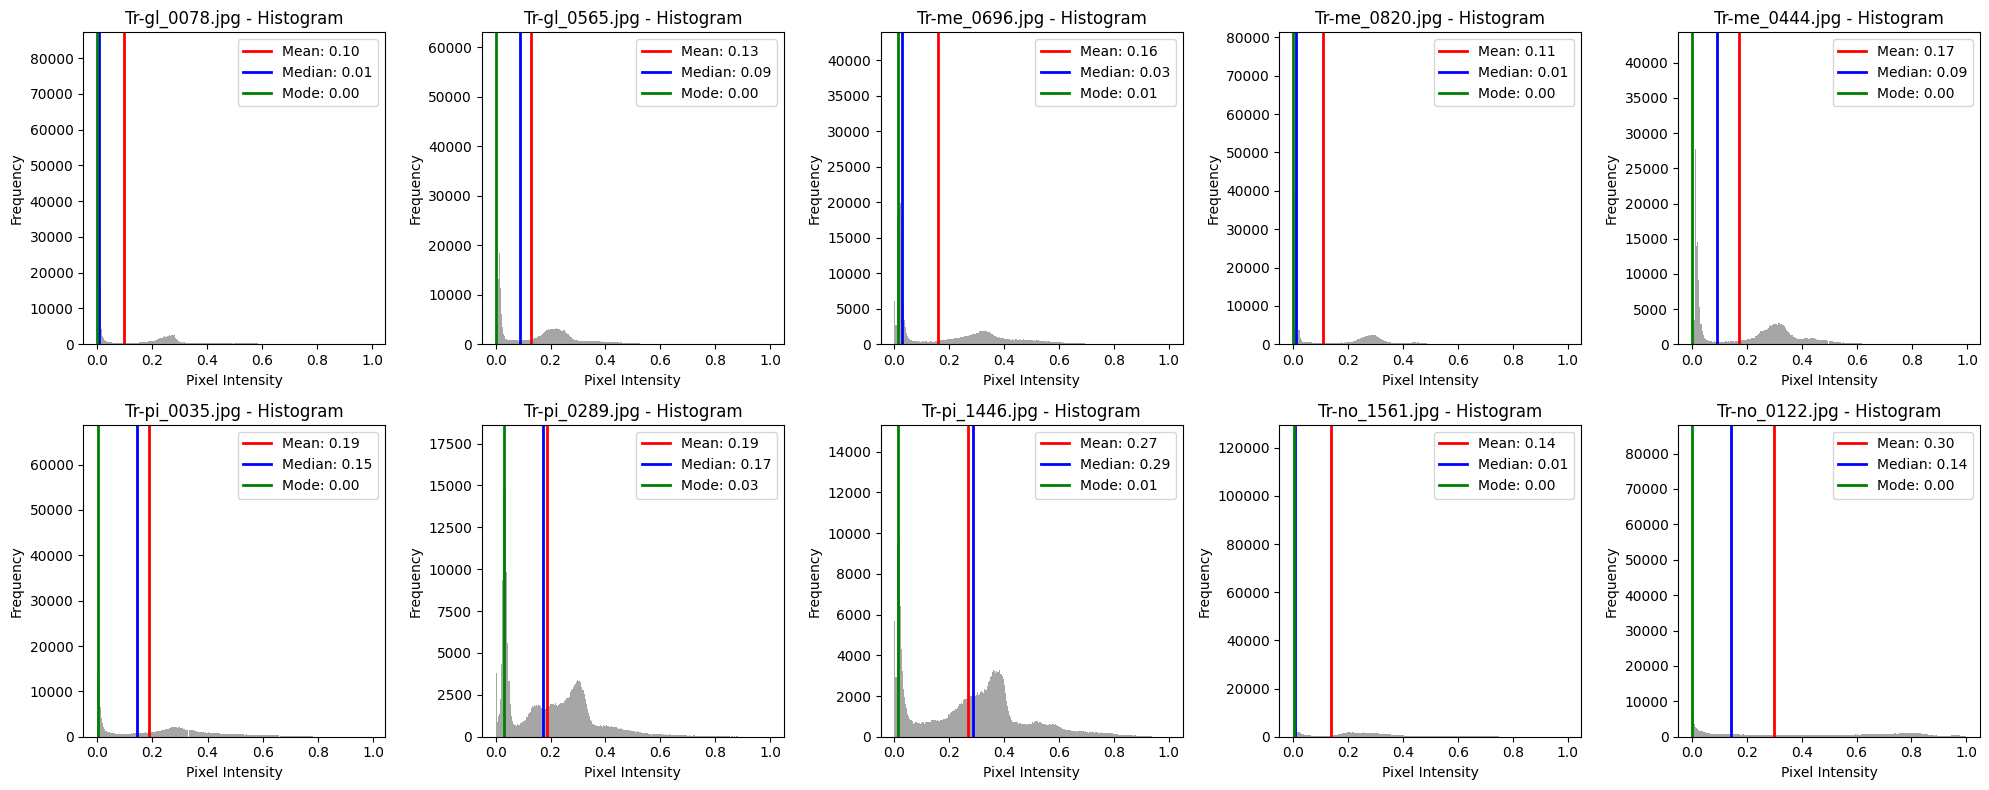

In [12]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    image = X_train_shuffled[idx].astype(np.float32)/255.0
    label = Y_train_shuffled[idx]
    ax = axes[i]
    ax.hist(image.ravel(), bins=256, color='gray', alpha=0.7)
    avg = np.mean(image)
    median = np.median(image)
    mode = stats.mode(image.ravel())[0]
    ax.axvline(avg, color='red', linestyle='solid', linewidth=2, label=f'Mean: {avg:.2f}')
    ax.axvline(median, color='blue', linestyle='solid', linewidth=2, label=f'Median: {median:.2f}')
    ax.axvline(mode, color='green', linestyle='solid', linewidth=2, label=f'Mode: {mode:.2f}')
    ax.set_title(f'{random_indices_file_names[i]} - Histogram')
    ax.set_xlabel("Pixel Intensity")
    ax.set_ylabel("Frequency")
    ax.legend()

plt.tight_layout()
plt.show()

Plot the 10 randomly selected images with certain brightness/contrast transformations: gamma correction, histogram equalization, and contrast stretching.

In [13]:
num_plots_per_row = 6
fig, axes = plt.subplots(int(ceil(10*6/num_plots_per_row)), num_plots_per_row, figsize=(20, 50))
axes = axes.ravel()
i = 0
for idx in random_indices:
    image = X_train_shuffled[idx]
    gamma_corrected = gamma_correction(image, 2.5)
    gamma_corrected_sigmoid = gamma_correction(image, 2.5, with_sigmoid=True)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    histogram_equalized = clahe.apply(image)
    contrast_stretched = contrast_stretching(image)

    image = image.astype(np.float32)/255.0
    mean_pixel_intensity = np.mean(image)
    brightness_adjusted_img = image.copy()
    # lower brights
    if (mean_pixel_intensity > 0.3):
      bright_mask = image > 0.6
      brightness_adjusted_img[bright_mask] = brightness_adjusted_img[bright_mask] * 0.2
    # brighten darks
    elif (mean_pixel_intensity < 0.15):
      dark_mask = image < 0.2
      brightness_adjusted_img[dark_mask] = brightness_adjusted_img[dark_mask] * 2.0

    label = os.path.basename(image_path)
    ax = axes[i]
    ax.imshow(image, cmap='gray')
    ax.set_title(f"{label}\n  (original)")
    ax.axis('off')
    i += 1
    ax = axes[i]
    ax.imshow(gamma_corrected, cmap='gray')
    ax.set_title(f"{label}\n  (gamma corrected)")
    ax.axis('off')
    i += 1
    ax = axes[i]
    ax.imshow(gamma_corrected_sigmoid, cmap='gray')
    ax.set_title(f"{label}\n  (gamma corrected sigmoid)")
    ax.axis('off')
    i += 1
    ax = axes[i]
    ax.imshow(histogram_equalized, cmap='gray')
    ax.set_title(f"{label}\n (histogram equalized)")
    ax.axis('off')
    i += 1
    ax = axes[i]
    ax.imshow(contrast_stretched, cmap='gray')
    ax.set_title(f"{label}\n  (contrast stretched)")
    ax.axis('off')
    i += 1
    ax = axes[i]
    ax.imshow(brightness_adjusted_img, cmap='gray')
    ax.set_title(f"{label}\n  (brightness adjusted)")
    ax.axis('off')
    i += 1

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Problematic Images

On observation of the training data, there are several possible inconsistencies:
1. some images are too bright or dark.
2. some images are grayscale inverted (GSI). Normally, internal cavity-like structures, such as ventricles, are darker in color than the surrounding organs, such as the brain, eyes, esophagus, etc. Some images, however, have this inverted, wherein the internal cavity-like structures are brighter instead.
3. some images have text.
4. some images have aliasing, caused by .jpg compression.

There can also be other inconsistencies.
We hand pick 15 problematic images (mostly constrained to #1 and #2 in the list mentioned above) to analyze.

In [14]:
problematic_file_paths = [
    "pituitary/Tr-pi_1146.jpg",
    "pituitary/Tr-pi_0995.jpg",
    "notumor/Tr-noTr_0007.jpg",
    "notumor/Tr-noTr_0005.jpg",
    "notumor/Tr-no_1586.jpg",
    "notumor/Tr-no_1539.jpg",
    "notumor/Tr-no_0122.jpg",
    "notumor/Tr-no_0010.jpg",
    "notumor/Tr-no_0053.jpg",
    "notumor/Tr-no_0072.jpg",
    "meningioma/Tr-me_1051.jpg",
    "meningioma/Tr-me_0915.jpg",
    "glioma/Tr-glTr_0006.jpg",
    "glioma/Tr-gl_0906.jpg",
    "glioma/Tr-gl_1051.jpg"
]
problematic_file_paths = [os.path.join(training_path, path) for path in problematic_file_paths]

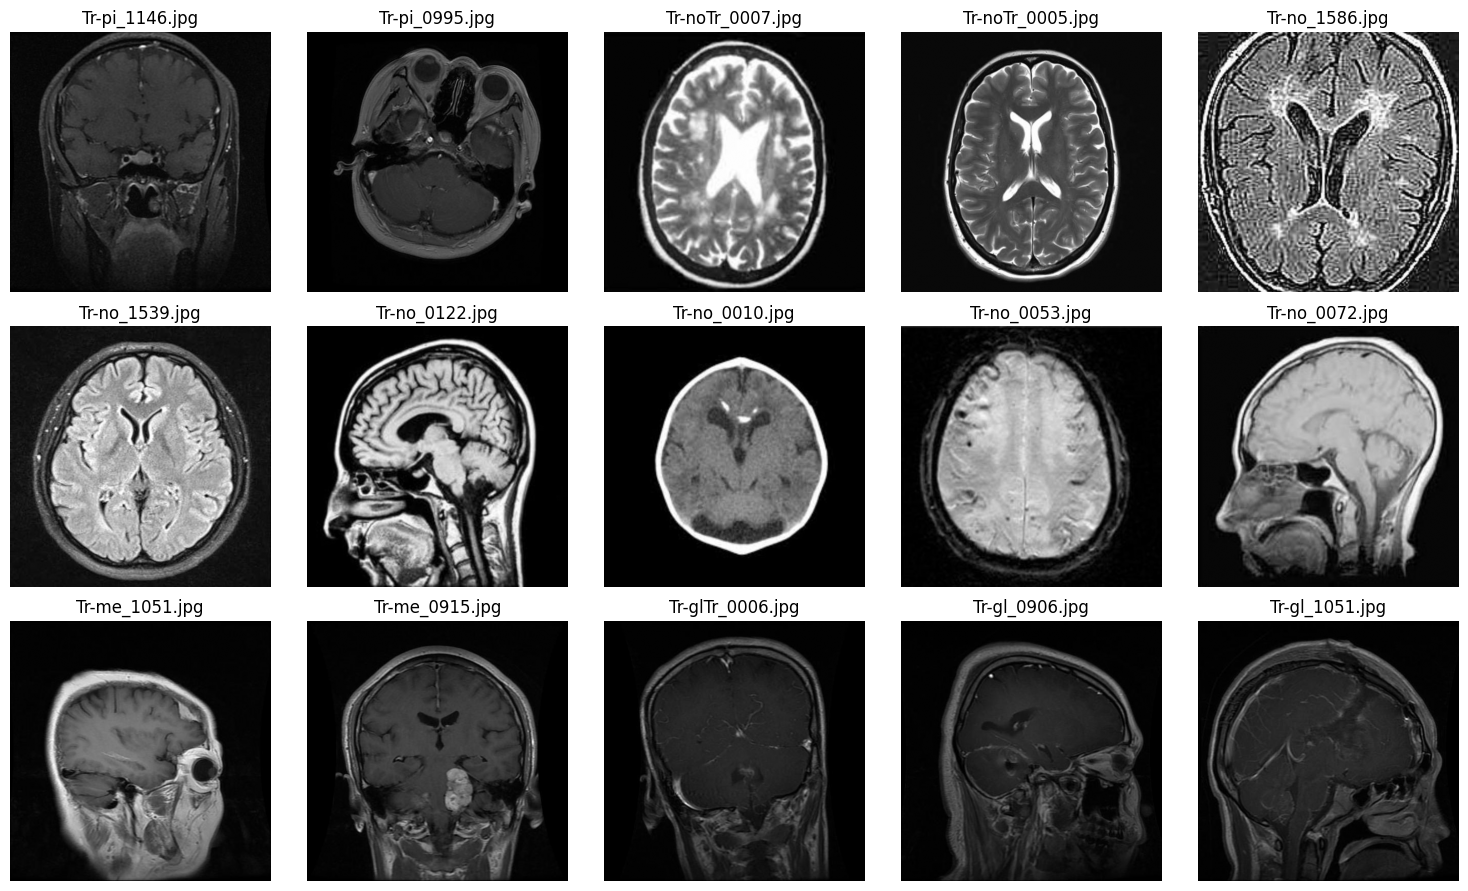

In [15]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.ravel()

for i, image_path in enumerate(problematic_file_paths):
    image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    label = os.path.basename(image_path)
    ax = axes[i]
    ax.imshow(image, cmap='gray')
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

Plot the pixel intensity histograms of the 15 problematic images.

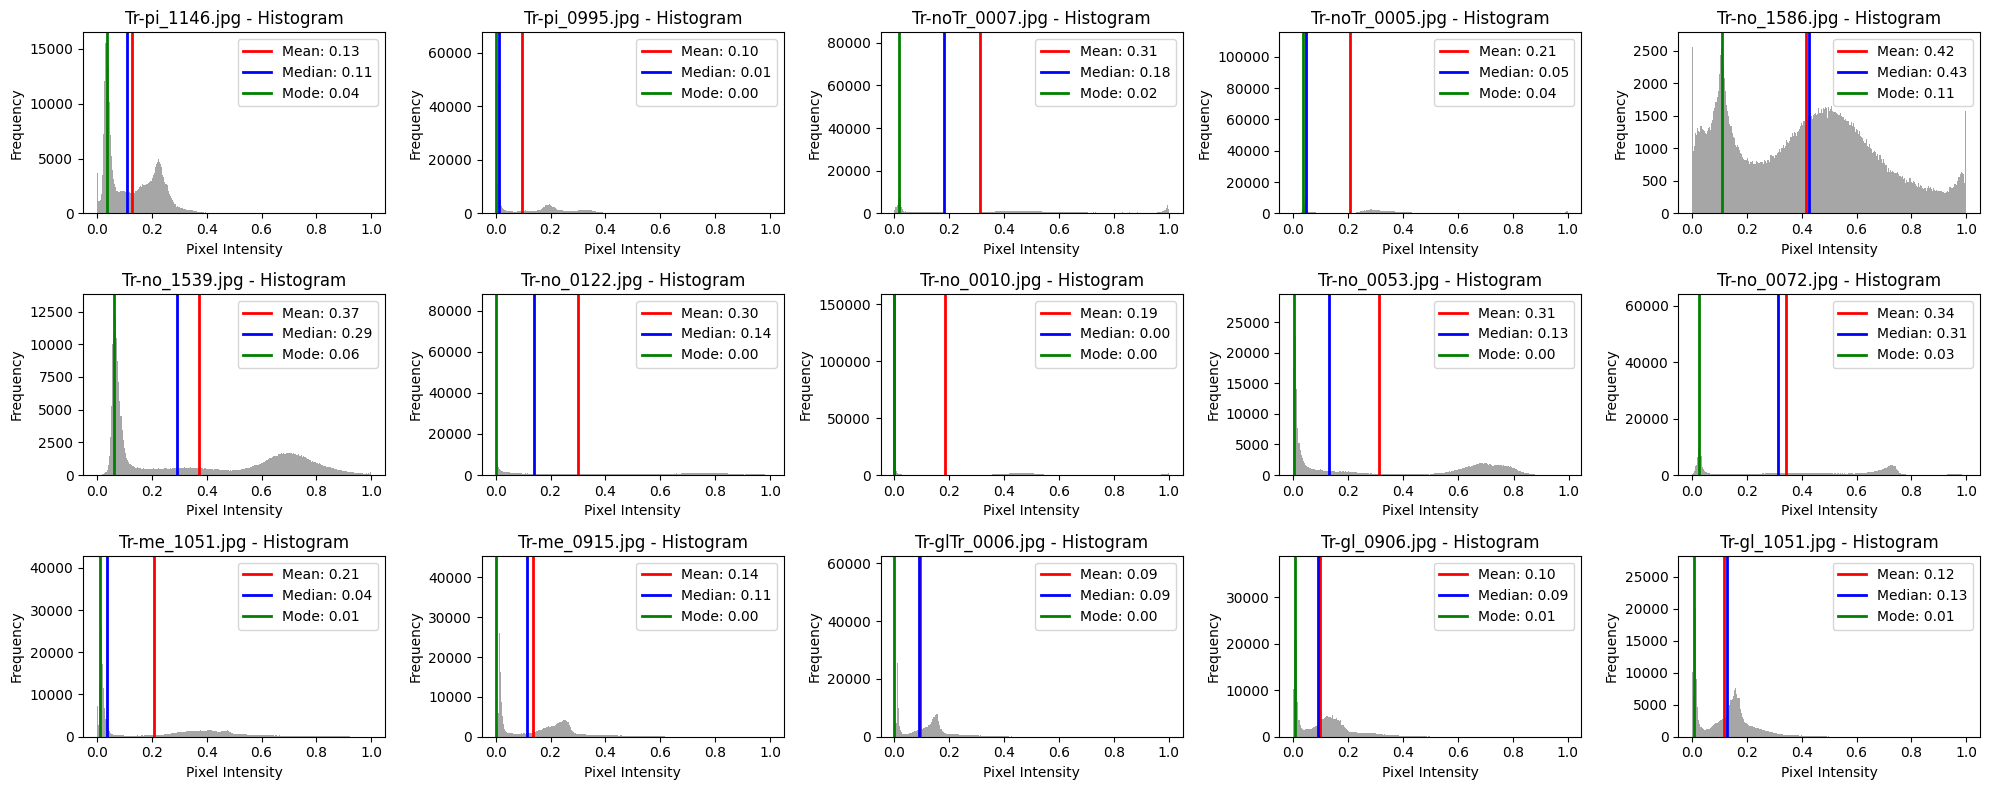

In [16]:
fig, axes = plt.subplots(3, 5, figsize=(20, 8))
axes = axes.ravel()

for i, image_path in enumerate(problematic_file_paths):
    image = cv.imread(image_path, cv.IMREAD_GRAYSCALE).astype(np.float32)/255.0
    label = os.path.basename(image_path)
    ax = axes[i]
    ax.hist(image.ravel(), bins=256, color='gray', alpha=0.7)
    avg = np.mean(image)
    median = np.median(image)
    mode = stats.mode(image.ravel())[0]
    ax.axvline(avg, color='red', linestyle='solid', linewidth=2, label=f'Mean: {avg:.2f}')
    ax.axvline(median, color='blue', linestyle='solid', linewidth=2, label=f'Median: {median:.2f}')
    ax.axvline(mode, color='green', linestyle='solid', linewidth=2, label=f'Mode: {mode:.2f}')
    ax.set_title(f'{label} - Histogram')
    ax.set_xlabel("Pixel Intensity")
    ax.set_ylabel("Frequency")
    ax.legend()

plt.tight_layout()
plt.show()

Plot the 15 problematic images with certain brightness/contrast transformations: gamma correction, histogram equalization, and contrast stretching.

In [17]:
num_plots_per_row = 6
fig, axes = plt.subplots(int(ceil(len(problematic_file_paths)*6/num_plots_per_row)), num_plots_per_row, figsize=(20, 50))
axes = axes.ravel()
i = 0
for image_path in problematic_file_paths:
    image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    gamma_corrected = gamma_correction(image, 2.5)
    gamma_corrected_sigmoid = gamma_correction(image, 2.5, with_sigmoid=True)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    histogram_equalized = clahe.apply(image)
    contrast_stretched = contrast_stretching(image)

    image = image.astype(np.float32)/255.0
    mean_pixel_intensity = np.mean(image)
    brightness_adjusted_img = image.copy()
    # lower brights
    if (mean_pixel_intensity > 0.3):
      bright_mask = image > 0.6
      brightness_adjusted_img[bright_mask] = brightness_adjusted_img[bright_mask] * 0.2
    # brighten darks
    elif (mean_pixel_intensity < 0.15):
      dark_mask = image < 0.2
      brightness_adjusted_img[dark_mask] = brightness_adjusted_img[dark_mask] * 2.0

    label = os.path.basename(image_path)
    ax = axes[i]
    ax.imshow(image, cmap='gray')
    ax.set_title(f"{label}\n  (original)")
    ax.axis('off')
    i += 1
    ax = axes[i]
    ax.imshow(gamma_corrected, cmap='gray')
    ax.set_title(f"{label}\n  (gamma corrected)")
    ax.axis('off')
    i += 1
    ax = axes[i]
    ax.imshow(gamma_corrected_sigmoid, cmap='gray')
    ax.set_title(f"{label}\n  (gamma corrected sigmoid)")
    ax.axis('off')
    i += 1
    ax = axes[i]
    ax.imshow(histogram_equalized, cmap='gray')
    ax.set_title(f"{label}\n (histogram equalized)")
    ax.axis('off')
    i += 1
    ax = axes[i]
    ax.imshow(contrast_stretched, cmap='gray')
    ax.set_title(f"{label}\n  (contrast stretched)")
    ax.axis('off')
    i += 1
    ax = axes[i]
    ax.imshow(brightness_adjusted_img, cmap='gray')
    ax.set_title(f"{label}\n  (brightness adjusted)")
    ax.axis('off')
    i += 1

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## II. Feature Exploration
For blob detection, we considered several apporaches and narrowed down to 2 features: Difference of Gaussians (DoG) and Determinant of Hessian (DoH). [Here](https://scikit-image.org/docs/0.23.x/auto_examples/features_detection/plot_blob.html) is the `scikit-image` documentation for reference.
1. **DoG**: each image is blurred with gaussian filters of increasing standard deviations (`min_sigma` to `max_sigma`). The differences between successive blurred images are taken and stacked in a cube. Blobs are identified as the local maximas in this cube and can be further pruned using an intensity `threshold` parameter. DoG is most suited for bright blobs on dark backgrounds. It's also a faster approximation of LoG (Laplacian of Gaussian) and we found it to identify blobs for broadly.
2. **DoH**: for each image, the matrix of the Determinant of Hessian is calculated at different scales (i.e. Hessian matrices are computed from Guassian kernels with standard deviations ranging from `min_sigma` to `max_sigma`). Blobs are identified as the local maximas in this matrix and can similarly be pruned with a `threshold` parameter. DoH is suited for both bright on dark and dark on bright blobs. In our case, this is suitable for gliomas, which often show up dark on bright. It is also the fastest blob detection method out of the 3 (DoG, DoH, and LoG).

To construct the features, we explored what pre-processing steps were suitable and came up with the following steps:
1. apply CLAHE for contrast equalization
2. apply a vignette for skull stripping

We tuned the hyperparameters used during the preprocessing and feature generation steps.

### Difference of Gaussians (DoG)

Without pre-processing:

In [18]:
num_plots_per_row = 8
fig, ax = plt.subplots(int(len(random_indices)*4/num_plots_per_row), num_plots_per_row, figsize=(30, 20))

ax_idx = 0

for i, index in enumerate(random_indices):
  image = X_train_shuffled[index].astype(np.float32)/255.0
  label = Y_train_shuffled[index]

  img_masked = image.copy()

  # Apply DoG
  large_low_sigma, large_high_sigma = 30, 40
  small_low_sigma, small_high_sigma = 20, 30
  dog_image_large_blobs = difference_of_gaussians(img_masked, large_low_sigma, large_high_sigma)
  dog_image_small_blobs = difference_of_gaussians(img_masked, small_low_sigma, small_high_sigma)
  blobs_dog_small = blob_dog(img_masked, min_sigma=small_low_sigma, max_sigma=small_high_sigma, threshold=0.078)
  blobs_dog_small[:, 2] = blobs_dog_small[:, 2] * np.sqrt(2)
  blobs_dog_large = blob_dog(img_masked, min_sigma=large_low_sigma, max_sigma=large_high_sigma, threshold=0.056)
  blobs_dog_large[:, 2] = blobs_dog_large[:, 2] * np.sqrt(2)
  # Rescale for better display
  dog_image_large_blobs_rescaled = exposure.rescale_intensity(dog_image_large_blobs, in_range=(0, 0.3))
  dog_image_small_blobs_rescaled = exposure.rescale_intensity(dog_image_small_blobs, in_range=(0, 0.3))

  # plot
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(preprocessed)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(img_masked, cmap="gray")
  ax_idx += 1
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(small DoG)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(dog_image_small_blobs_rescaled, cmap="gray")
  ax_idx += 1
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(large DoG)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(dog_image_large_blobs_rescaled, cmap="gray")
  ax_idx += 1
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(DoG circles)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(image, cmap="gray")
  if blobs_dog_small.shape[0] > 0:
    print(f"label={label}, blobs_dog_small=\n{blobs_dog_small}")
    for blob in blobs_dog_small:
      y, x, r = blob
      c = plt.Circle((x, y), r, color='yellow', linewidth=5, fill=False)
      ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].add_patch(c)
  if blobs_dog_large.shape[0] > 0:
    print(f"label={label}, blobs_dog_large=\n{blobs_dog_large}")
    for blob in blobs_dog_large:
      y, x, r = blob
      c = plt.Circle((x, y), r, color='red', linewidth=5, fill=False)
      ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].add_patch(c)
  ax_idx += 1

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

With pre-processing:

In [19]:
num_plots_per_row = 8
fig, ax = plt.subplots(int(len(random_indices)*4/num_plots_per_row), num_plots_per_row, figsize=(30, 20))

ax_idx = 0

for i, index in enumerate(random_indices):
  image = X_train_shuffled[index]
  label = Y_train_shuffled[index]

  img_masked = preprocess_image_dog(image) # see utils.py for implementation

  # Apply DoG
  large_low_sigma, large_high_sigma = 24, 40
  small_low_sigma, small_high_sigma = 20, 30
  dog_image_large_blobs = difference_of_gaussians(img_masked, large_low_sigma, large_high_sigma)
  dog_image_small_blobs = difference_of_gaussians(img_masked, small_low_sigma, small_high_sigma)
  blobs_dog_small = blob_dog(img_masked, min_sigma=small_low_sigma, max_sigma=small_high_sigma, threshold=0.078)
  blobs_dog_small[:, 2] = blobs_dog_small[:, 2] * np.sqrt(2)
  blobs_dog_large = blob_dog(img_masked, min_sigma=large_low_sigma, max_sigma=large_high_sigma, threshold=0.056)
  blobs_dog_large[:, 2] = blobs_dog_large[:, 2] * np.sqrt(2)
  # Rescale for better display
  dog_image_large_blobs_rescaled = exposure.rescale_intensity(dog_image_large_blobs, in_range=(0, 0.3))
  dog_image_small_blobs_rescaled = exposure.rescale_intensity(dog_image_small_blobs, in_range=(0, 0.3))

  # plot
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(preprocessed)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(img_masked, cmap="gray")
  ax_idx += 1
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(small DoG)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(dog_image_small_blobs_rescaled, cmap="gray")
  ax_idx += 1
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(large DoG)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(dog_image_large_blobs_rescaled, cmap="gray")
  ax_idx += 1
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(DoG circles)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(image, cmap="gray")
  if blobs_dog_small.shape[0] > 0:
    print(f"label={label}, blobs_dog_small=\n{blobs_dog_small}")
    for blob in blobs_dog_small:
      y, x, r = blob
      c = plt.Circle((x, y), r, color='yellow', linewidth=5, fill=False)
      ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].add_patch(c)
  if blobs_dog_large.shape[0] > 0:
    print(f"label={label}, blobs_dog_large=\n{blobs_dog_large}")
    for blob in blobs_dog_large:
      y, x, r = blob
      c = plt.Circle((x, y), r, color='red', linewidth=5, fill=False)
      ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].add_patch(c)
  ax_idx += 1

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### Problematic Images

Try the same DoG calculations for the 15 problematic images.\
Without pre-processing:

In [20]:
num_plots_per_row = 4
fig, ax = plt.subplots(int(ceil(len(problematic_file_paths)*4/num_plots_per_row)), num_plots_per_row, figsize=(10, 50))

ax_idx = 0

for i, image_path in enumerate(problematic_file_paths):
  image = cv.imread(image_path, cv.IMREAD_GRAYSCALE).astype(np.float32)/255.0
  label = os.path.basename(image_path)

  img_masked = image.copy()

  # Apply DoG
  large_low_sigma, large_high_sigma = 30, 40
  small_low_sigma, small_high_sigma = 20, 30
  dog_image_large_blobs = difference_of_gaussians(img_masked, large_low_sigma, large_high_sigma)
  dog_image_small_blobs = difference_of_gaussians(img_masked, small_low_sigma, small_high_sigma)
  blobs_dog_small = blob_dog(img_masked, min_sigma=small_low_sigma, max_sigma=small_high_sigma, threshold=0.078)
  blobs_dog_small[:, 2] = blobs_dog_small[:, 2] * np.sqrt(2)
  blobs_dog_large = blob_dog(img_masked, min_sigma=large_low_sigma, max_sigma=large_high_sigma, threshold=0.056)
  blobs_dog_large[:, 2] = blobs_dog_large[:, 2] * np.sqrt(2)
  # Rescale for better display
  dog_image_large_blobs_rescaled = exposure.rescale_intensity(dog_image_large_blobs, in_range=(0, 0.3))
  dog_image_small_blobs_rescaled = exposure.rescale_intensity(dog_image_small_blobs, in_range=(0, 0.3))

  # plot
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(original)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(img_masked, cmap="gray")
  ax_idx += 1
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(small DoG)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(dog_image_small_blobs_rescaled, cmap="gray")
  ax_idx += 1
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(large DoG)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(dog_image_large_blobs_rescaled, cmap="gray")
  ax_idx += 1
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(DoG circles)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(image, cmap="gray")
  if blobs_dog_small.shape[0] > 0:
    print(f"label={label}, blobs_dog_small=\n{blobs_dog_small}")
    for blob in blobs_dog_small:
      y, x, r = blob
      c = plt.Circle((x, y), r, color='yellow', linewidth=5, fill=False)
      ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].add_patch(c)
  if blobs_dog_large.shape[0] > 0:
    print(f"label={label}, blobs_dog_large=\n{blobs_dog_large}")
    for blob in blobs_dog_large:
      y, x, r = blob
      c = plt.Circle((x, y), r, color='red', linewidth=5, fill=False)
      ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].add_patch(c)
  ax_idx += 1

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

With pre-processing:

In [21]:
num_plots_per_row = 4
fig, ax = plt.subplots(int(ceil(len(problematic_file_paths)*4/num_plots_per_row)), num_plots_per_row, figsize=(10, 50))

ax_idx = 0

for i, image_path in enumerate(problematic_file_paths):
  image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
  label = os.path.basename(image_path)

  img_masked = preprocess_image_dog(image) # see utils.py for implementation

  # Apply DoG
  large_low_sigma, large_high_sigma = 24, 40
  small_low_sigma, small_high_sigma = 20, 30
  dog_image_large_blobs = difference_of_gaussians(img_masked, large_low_sigma, large_high_sigma)
  dog_image_small_blobs = difference_of_gaussians(img_masked, small_low_sigma, small_high_sigma)
  blobs_dog_small = blob_dog(img_masked, min_sigma=small_low_sigma, max_sigma=small_high_sigma, threshold=0.078)
  blobs_dog_small[:, 2] = blobs_dog_small[:, 2] * np.sqrt(2)
  blobs_dog_large = blob_dog(img_masked, min_sigma=large_low_sigma, max_sigma=large_high_sigma, threshold=0.056)
  blobs_dog_large[:, 2] = blobs_dog_large[:, 2] * np.sqrt(2)
  # Rescale for better display
  dog_image_large_blobs_rescaled = exposure.rescale_intensity(dog_image_large_blobs, in_range=(0, 0.3))
  dog_image_small_blobs_rescaled = exposure.rescale_intensity(dog_image_small_blobs, in_range=(0, 0.3))

  # plot
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(preprocessed)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(img_masked, cmap="gray")
  ax_idx += 1
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(small DoG)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(dog_image_small_blobs_rescaled, cmap="gray")
  ax_idx += 1
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(large DoG)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(dog_image_large_blobs_rescaled, cmap="gray")
  ax_idx += 1
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(DoG circles)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(image, cmap="gray")
  if blobs_dog_small.shape[0] > 0:
    print(f"label={label}, blobs_dog_small=\n{blobs_dog_small}")
    for blob in blobs_dog_small:
      y, x, r = blob
      c = plt.Circle((x, y), r, color='yellow', linewidth=5, fill=False)
      ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].add_patch(c)
  if blobs_dog_large.shape[0] > 0:
    print(f"label={label}, blobs_dog_large=\n{blobs_dog_large}")
    for blob in blobs_dog_large:
      y, x, r = blob
      c = plt.Circle((x, y), r, color='red', linewidth=5, fill=False)
      ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].add_patch(c)
  ax_idx += 1

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Determinant of Hessian (DoH)

Without pre-processing:

In [22]:
num_plots_per_row = 8
fig, ax = plt.subplots(int(len(random_indices)*4/num_plots_per_row), num_plots_per_row, figsize=(30, 20))

ax_idx = 0

for i, index in enumerate(random_indices):
  image = X_train_shuffled[index].astype(np.float32)/255.0
  label = Y_train_shuffled[index]

  img_masked = image.copy()

  # Apply DoH
  large_low_sigma, large_high_sigma = 25, 45
  small_low_sigma, small_high_sigma = 10, 30
  doh_image_large_blobs = hessian_matrix_det(img_masked, large_low_sigma)
  doh_image_small_blobs = hessian_matrix_det(img_masked, small_low_sigma)
  blobs_doh_small = blob_doh(img_masked, min_sigma=small_low_sigma, max_sigma=small_high_sigma, threshold=0.002)
  blobs_doh_small[:, 2] = blobs_doh_small[:, 2] * np.sqrt(2)
  blobs_doh_large = blob_doh(img_masked, min_sigma=large_low_sigma, max_sigma=large_high_sigma, threshold=0.0015)
  blobs_doh_large[:, 2] = blobs_doh_large[:, 2] * np.sqrt(2)
  # Rescale for better display
  doh_image_large_blobs_rescaled = exposure.rescale_intensity(doh_image_large_blobs, in_range=(0, 0.0001))
  doh_image_small_blobs_rescaled = exposure.rescale_intensity(doh_image_small_blobs, in_range=(0, 0.0001))

  # plot
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(preprocessed)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(img_masked, cmap="gray")
  ax_idx += 1
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(small DoH)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(doh_image_small_blobs_rescaled, cmap="gray")
  ax_idx += 1
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(large DoH)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(doh_image_large_blobs_rescaled, cmap="gray")
  ax_idx += 1
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(DoH circles)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(image, cmap="gray")
  if blobs_doh_small.shape[0] > 0:
    print(f"label={label}, blobs_doh_small=\n{blobs_doh_small}")
    for blob in blobs_doh_small:
      y, x, r = blob
      c = plt.Circle((x, y), r, color='yellow', linewidth=5, fill=False)
      ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].add_patch(c)
  if blobs_doh_large.shape[0] > 0:
    print(f"label={label}, blobs_doh_large=\n{blobs_doh_large}")
    for blob in blobs_doh_large:
      y, x, r = blob
      c = plt.Circle((x, y), r, color='red', linewidth=5, fill=False)
      ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].add_patch(c)
  ax_idx += 1

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

With pre-processing:

In [23]:
num_plots_per_row = 8
fig, ax = plt.subplots(int(len(random_indices)*4/num_plots_per_row), num_plots_per_row, figsize=(30, 20))

ax_idx = 0

for i, index in enumerate(random_indices):
  image = X_train_shuffled[index]
  label = Y_train_shuffled[index]

  img_masked = preprocess_image_doh(image) # see utils.py for implementation

  # Apply DoH
  large_low_sigma, large_high_sigma = 30, 45
  small_low_sigma, small_high_sigma = 10, 30
  doh_image_large_blobs = hessian_matrix_det(img_masked, large_low_sigma)
  doh_image_small_blobs = hessian_matrix_det(img_masked, small_low_sigma)
  blobs_doh_small = blob_doh(img_masked, min_sigma=small_low_sigma, max_sigma=small_high_sigma, threshold=0.0025)
  blobs_doh_small[:, 2] = blobs_doh_small[:, 2] * np.sqrt(2)
  blobs_doh_large = blob_doh(img_masked, min_sigma=large_low_sigma, max_sigma=large_high_sigma, threshold=0.0015)
  blobs_doh_large[:, 2] = blobs_doh_large[:, 2] * np.sqrt(2)
  # Rescale for better display
  doh_image_large_blobs_rescaled = exposure.rescale_intensity(doh_image_large_blobs, in_range=(0, 0.0001))
  doh_image_small_blobs_rescaled = exposure.rescale_intensity(doh_image_small_blobs, in_range=(0, 0.0001))

  # plot
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(preprocessed)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(img_masked, cmap="gray")
  ax_idx += 1
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(small DoH)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(doh_image_small_blobs_rescaled, cmap="gray")
  ax_idx += 1
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(large DoH)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(doh_image_large_blobs_rescaled, cmap="gray")
  ax_idx += 1
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(DoH circles)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(image, cmap="gray")
  if blobs_doh_small.shape[0] > 0:
    print(f"label={label}, blobs_doh_small=\n{blobs_doh_small}")
    for blob in blobs_doh_small:
      y, x, r = blob
      c = plt.Circle((x, y), r, color='yellow', linewidth=5, fill=False)
      ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].add_patch(c)
  if blobs_doh_large.shape[0] > 0:
    print(f"label={label}, blobs_doh_large=\n{blobs_doh_large}")
    for blob in blobs_doh_large:
      y, x, r = blob
      c = plt.Circle((x, y), r, color='red', linewidth=5, fill=False)
      ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].add_patch(c)
  ax_idx += 1

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### Problematic Images

Try the same DoH calculations for the 15 problematic images.\
Without pre-processing:

In [24]:
num_plots_per_row = 4
fig, ax = plt.subplots(int(ceil(len(problematic_file_paths)*4/num_plots_per_row)), num_plots_per_row, figsize=(10, 50))

ax_idx = 0

for i, image_path in enumerate(problematic_file_paths):
  image = cv.imread(image_path, cv.IMREAD_GRAYSCALE).astype(np.float32)/255.0
  label = os.path.basename(image_path)

  img_masked = image.copy()

  # Apply DoH
  large_low_sigma, large_high_sigma = 25, 45
  small_low_sigma, small_high_sigma = 10, 30
  doh_image_large_blobs = hessian_matrix_det(img_masked, large_low_sigma)
  doh_image_small_blobs = hessian_matrix_det(img_masked, small_low_sigma)
  blobs_doh_small = blob_doh(img_masked, min_sigma=small_low_sigma, max_sigma=small_high_sigma, threshold=0.002)
  blobs_doh_small[:, 2] = blobs_doh_small[:, 2] * np.sqrt(2)
  blobs_doh_large = blob_doh(img_masked, min_sigma=large_low_sigma, max_sigma=large_high_sigma, threshold=0.0015)
  blobs_doh_large[:, 2] = blobs_doh_large[:, 2] * np.sqrt(2)
  # Rescale for better display
  doh_image_large_blobs_rescaled = exposure.rescale_intensity(doh_image_large_blobs, in_range=(0, 0.0001))
  doh_image_small_blobs_rescaled = exposure.rescale_intensity(doh_image_small_blobs, in_range=(0, 0.0001))

  # plot
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(preprocessed)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(img_masked, cmap="gray")
  ax_idx += 1
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(small DoH)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(doh_image_small_blobs_rescaled, cmap="gray")
  ax_idx += 1
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(large DoH)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(doh_image_large_blobs_rescaled, cmap="gray")
  ax_idx += 1
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(DoH circles)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(image, cmap="gray")
  if blobs_doh_small.shape[0] > 0:
    print(f"label={label}, blobs_doh_small=\n{blobs_doh_small}")
    for blob in blobs_doh_small:
      y, x, r = blob
      c = plt.Circle((x, y), r, color='yellow', linewidth=5, fill=False)
      ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].add_patch(c)
  if blobs_doh_large.shape[0] > 0:
    print(f"label={label}, blobs_doh_large=\n{blobs_doh_large}")
    for blob in blobs_doh_large:
      y, x, r = blob
      c = plt.Circle((x, y), r, color='red', linewidth=5, fill=False)
      ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].add_patch(c)
  ax_idx += 1

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

With pre-processing:

In [25]:
num_plots_per_row = 4
fig, ax = plt.subplots(int(ceil(len(problematic_file_paths)*4/num_plots_per_row)), num_plots_per_row, figsize=(10, 50))

ax_idx = 0

for i, image_path in enumerate(problematic_file_paths):
  image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
  label = os.path.basename(image_path)

  img_masked = preprocess_image_doh(image) # see utils.py for implementation

  # Apply DoH
  large_low_sigma, large_high_sigma = 30, 45
  small_low_sigma, small_high_sigma = 10, 30
  doh_image_large_blobs = hessian_matrix_det(img_masked, large_low_sigma)
  doh_image_small_blobs = hessian_matrix_det(img_masked, small_low_sigma)
  blobs_doh_small = blob_doh(img_masked, min_sigma=small_low_sigma, max_sigma=small_high_sigma, threshold=0.0025)
  blobs_doh_small[:, 2] = blobs_doh_small[:, 2] * np.sqrt(2)
  blobs_doh_large = blob_doh(img_masked, min_sigma=large_low_sigma, max_sigma=large_high_sigma, threshold=0.0016)
  blobs_doh_large[:, 2] = blobs_doh_large[:, 2] * np.sqrt(2)
  # Rescale for better display
  doh_image_large_blobs_rescaled = exposure.rescale_intensity(doh_image_large_blobs, in_range=(0, 0.0001))
  doh_image_small_blobs_rescaled = exposure.rescale_intensity(doh_image_small_blobs, in_range=(0, 0.0001))

  # plot
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(preprocessed)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(img_masked, cmap="gray")
  ax_idx += 1
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(small DoH)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(doh_image_small_blobs_rescaled, cmap="gray")
  ax_idx += 1
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(large DoH)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(doh_image_large_blobs_rescaled, cmap="gray")
  ax_idx += 1
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_title(f'{label}\n(DoH circles)', fontsize=10)
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].set_axis_off()
  ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].imshow(image, cmap="gray")
  if blobs_doh_small.shape[0] > 0:
    print(f"label={label}, blobs_doh_small=\n{blobs_doh_small}")
    for blob in blobs_doh_small:
      y, x, r = blob
      c = plt.Circle((x, y), r, color='yellow', linewidth=5, fill=False)
      ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].add_patch(c)
  if blobs_doh_large.shape[0] > 0:
    print(f"label={label}, blobs_doh_large=\n{blobs_doh_large}")
    for blob in blobs_doh_large:
      y, x, r = blob
      c = plt.Circle((x, y), r, color='red', linewidth=5, fill=False)
      ax[ax_idx//num_plots_per_row,ax_idx%num_plots_per_row].add_patch(c)
  ax_idx += 1

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## III. Generate Features

In [12]:
train_paths = get_paths(image_file_paths)
train_paths

array([['/Training/glioma/Tr-gl_0952.jpg'],
       ['/Training/glioma/Tr-gl_0860.jpg'],
       ['/Training/glioma/Tr-gl_0640.jpg'],
       ...,
       ['/Training/pituitary/Tr-pi_0777.jpg'],
       ['/Training/pituitary/Tr-pi_0889.jpg'],
       ['/Training/pituitary/Tr-pi_0760.jpg']], dtype='<U37')

In [13]:
test_paths = get_paths(test_image_file_paths)
test_paths

array([['/Testing/glioma/Te-gl_0112.jpg'],
       ['/Testing/glioma/Te-gl_0146.jpg'],
       ['/Testing/glioma/Te-gl_0274.jpg'],
       ...,
       ['/Testing/pituitary/Te-pi_0147.jpg'],
       ['/Testing/pituitary/Te-piTr_0003.jpg'],
       ['/Testing/pituitary/Te-pi_0109.jpg']], dtype='<U36')

Generate features and save as .npy:

In [ ]:
X_train_dog_features = get_features(np.array(X_train), feat_name='blob_dog')
paths_and_X_train_dog_features = np.hstack((train_paths, X_train_dog_features))
np.save('X_train_dog_features.npy', paths_and_X_train_dog_features)

Blob Dog Images: 100%|██████████| 5712/5712 [1:36:44<00:00,  1.02s/it]


In [ ]:
X_train_doh_features = get_features(np.array(X_train), feat_name='blob_doh')
paths_and_X_train_doh_features = np.hstack((train_paths, X_train_doh_features))
np.save('X_train_doh_features.npy', paths_and_X_train_doh_features)

Blob DoH images: 100%|██████████| 5712/5712 [43:19<00:00,  2.20it/s]


In [ ]:
X_test_dog_features = get_features(np.array(X_test), feat_name='blob_dog')
paths_and_X_test_dog_features = np.hstack((test_paths, X_test_dog_features))
np.save('X_test_dog_features.npy', paths_and_X_test_dog_features)

Blob Dog Images: 100%|██████████| 1311/1311 [22:46<00:00,  1.04s/it]


In [ ]:
X_test_doh_features = get_features(np.array(X_test), feat_name='blob_doh')
paths_and_X_test_doh_features = np.hstack((test_paths, X_test_doh_features))
np.save('X_test_doh_features.npy', paths_and_X_test_doh_features)

Blob DoH images: 100%|██████████| 1311/1311 [11:42<00:00,  1.87it/s]


Save in aligned features CSVs:

In [ ]:
X_train_dog_df = pd.DataFrame({'filepath': X_train_dog_features[:,0],
                               'feat_dog': list(X_train_dog_features[:,1:])})
X_train_doh_df = pd.DataFrame({'filepath': X_train_doh_features[:,0],
                               'feat_doh': list(X_train_doh_features[:,1:])})
X_train_features_df = pd.merge(X_train_dog_df, X_train_doh_df, on='filepath')
display(X_train_features_df.head())

filepath  \
0  /Training/glioma/Tr-gl_0952.jpg   
1  /Training/glioma/Tr-gl_0860.jpg   
2  /Training/glioma/Tr-gl_0640.jpg   
3  /Training/glioma/Tr-gl_0831.jpg   
4  /Training/glioma/Tr-gl_0873.jpg   

                                            feat_dog  \
0  [3.0, 1.1444091796875e-05, 0.6165364583333334,...   
1  [6.0, 2.288818359375e-05, 0.583984375, 0.07415...   
2  [8.0, 3.0517578125e-05, 0.55712890625, 0.14380...   
3  [11.0, 4.1961669921875e-05, 0.5106534090909091...   
4  [3.0, 1.1444091796875e-05, 0.5475260416666666,...   

                                            feat_doh  
0  [15.0, 5.7220458984375e-05, 0.620703125, 0.076...  
1  [7.0, 2.6702880859375e-05, 0.5700334821428571,...  
2  [10.0, 3.814697265625e-05, 0.6052734375, 0.118...  
3  [14.0, 5.340576171875e-05, 0.5548270089285714,...  
4  [15.0, 5.7220458984375e-05, 0.6069010416666667...

In [ ]:
X_train_features_df.shape[0]

5712

In [ ]:
aligned_train_df = get_updated_aligned_features('aligned_training_features.csv', X_train_features_df)

feat_vec  target  \
0  [-1.24389648e-01  3.93554688e-01  1.46972656e-...       0   
1  [ 6.77734375e-01  7.03613281e-01  8.71582031e-...       0   
2  [ 8.52539062e-01 -6.66503906e-02 -6.14624023e-...       0   
3  [ 6.82617188e-01 -2.55126953e-01  5.60302734e-...       0   
4  [ 8.66699219e-01  3.56201172e-01  4.47021484e-...       0   

                            filepath               feat_canny  \
0  /Training/glioma/Tr-glTr_0000.jpg  [0. 0. 0. ... 0. 0. 0.]   
1  /Training/glioma/Tr-glTr_0001.jpg  [0. 0. 0. ... 0. 0. 0.]   
2  /Training/glioma/Tr-glTr_0002.jpg  [0. 0. 0. ... 0. 0. 0.]   
3  /Training/glioma/Tr-glTr_0003.jpg  [0. 0. 0. ... 0. 0. 0.]   
4  /Training/glioma/Tr-glTr_0004.jpg  [0. 0. 0. ... 0. 0. 0.]   

                                            feat_dog  \
0  [8.0, 3.0517578125e-05, 0.499755859375, 0.1059...   
1  [9.0, 3.4332275390625e-05, 0.5381944444444444,...   
2  [6.0, 2.288818359375e-05, 0.5706380208333334, ...   
3  [4.0, 1.52587890625e-05, 0.57666015625, 0.0594...   
4  [6.0, 2.288818359375e-05, 0.5582682291666666, ...   

                                            feat_doh  
0  [16.0, 6.103515625e-05, 0.5938720703125, 0.111...  
1  [10.0, 3.814697265625e-05, 0.5224609375, 0.149...  
2  [13.0, 4.9591064453125e-05, 0.5307992788461539...  
3  [5.0, 1.9073486328125e-05, 0.592578125, 0.1013...  
4  [12.0, 4.57763671875e-05, 0.5340169270833334, ...

In [ ]:
aligned_train_df.shape[0]

5712

In [ ]:
aligned_train_df.to_csv('aligned_training_features.csv', index=False)

In [ ]:
X_test_dog_df = pd.DataFrame({'filepath': X_test_dog_features[:,0],
                               'feat_dog': list(X_test_dog_features[:,1:])})
X_test_doh_df = pd.DataFrame({'filepath': X_test_doh_features[:,0],
                               'feat_doh': list(X_test_doh_features[:,1:])})
X_test_features_df = pd.merge(X_test_dog_df, X_test_doh_df, on='filepath')
display(X_test_features_df.head())

filepath  \
0  /Testing/glioma/Te-gl_0112.jpg   
1  /Testing/glioma/Te-gl_0146.jpg   
2  /Testing/glioma/Te-gl_0274.jpg   
3  /Testing/glioma/Te-gl_0203.jpg   
4  /Testing/glioma/Te-gl_0152.jpg   

                                            feat_dog  \
0  [2.0, 7.62939453125e-06, 0.4345703125, 0.02050...   
1  [6.0, 2.288818359375e-05, 0.5735677083333334, ...   
2  [5.0, 1.9073486328125e-05, 0.59140625, 0.06407...   
3  [4.0, 1.52587890625e-05, 0.6142578125, 0.08718...   
4  [4.0, 1.52587890625e-05, 0.62451171875, 0.1049...   

                                            feat_doh  
0  [3.0, 1.1444091796875e-05, 0.529296875, 0.0883...  
1  [11.0, 4.1961669921875e-05, 0.6278409090909091...  
2  [15.0, 5.7220458984375e-05, 0.5322916666666667...  
3  [9.0, 3.4332275390625e-05, 0.6786024305555556,...  
4  [11.0, 4.1961669921875e-05, 0.6058238636363636...

In [ ]:
X_test_features_df.shape[0]

1311

In [ ]:
aligned_test_df = get_updated_aligned_features('aligned_testing_features.csv', X_test_features_df)

feat_vec  target  \
0  [ 4.94384766e-01  7.06542969e-01  5.39062500e-...       0   
1  [ 7.76367188e-01  2.49389648e-01  1.30126953e-...       0   
2  [ 7.86132812e-01  8.71093750e-01 -5.54199219e-...       0   
3  [ 2.44140625e-01  7.33886719e-01  2.66113281e-...       0   
4  [ 9.73632812e-01  6.42578125e-01  9.85107422e-...       0   

                           filepath               feat_canny  \
0  /Testing/glioma/Te-glTr_0000.jpg  [0. 0. 0. ... 0. 0. 0.]   
1  /Testing/glioma/Te-glTr_0001.jpg  [0. 0. 0. ... 0. 0. 0.]   
2  /Testing/glioma/Te-glTr_0002.jpg  [0. 0. 0. ... 0. 0. 0.]   
3  /Testing/glioma/Te-glTr_0003.jpg  [0. 0. 0. ... 0. 0. 0.]   
4  /Testing/glioma/Te-glTr_0004.jpg  [0. 0. 0. ... 0. 0. 0.]   

                                            feat_dog  \
0  [8.0, 3.0517578125e-05, 0.5078125, 0.120037765...   
1  [6.0, 2.288818359375e-05, 0.48828125, 0.086637...   
2  [3.0, 1.1444091796875e-05, 0.37890625, 0.08599...   
3  [6.0, 2.288818359375e-05, 0.4983723958333333, ...   
4  [6.0, 2.288818359375e-05, 0.5390625, 0.0567415...   

                                            feat_doh  
0  [10.0, 3.814697265625e-05, 0.4328125, 0.117792...  
1  [10.0, 3.814697265625e-05, 0.426953125, 0.1351...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [26.0, 9.918212890625e-05, 0.4737079326923077,...  
4  [15.0, 5.7220458984375e-05, 0.48828125, 0.0757...

In [ ]:
aligned_test_df.shape[0]

1311

## V. Load Features

In [5]:
X_train_dog_features = np.load('X_train_dog_features.npy')
X_train_doh_features = np.load('X_train_doh_features.npy')

In [6]:
X_train_dog_features

array([['/Training/glioma/Tr-gl_0952.jpg', '3.0', '1.1444091796875e-05',
        ..., '0.02182534045808018', '0.05524271728019903',
        '0.10606601717798216'],
       ['/Training/glioma/Tr-gl_0860.jpg', '6.0', '2.288818359375e-05',
        ..., '0.022990529639940888', '0.05524271728019903',
        '0.10606601717798216'],
       ['/Training/glioma/Tr-gl_0640.jpg', '8.0', '3.0517578125e-05',
        ..., '0.020190060668672787', '0.05524271728019903',
        '0.10606601717798216'],
       ...,
       ['/Training/pituitary/Tr-pi_0777.jpg', '3.0',
        '1.1444091796875e-05', ..., '0.0052083333333333365',
        '0.05524271728019903', '0.06629126073623884'],
       ['/Training/pituitary/Tr-pi_0889.jpg', '2.0', '7.62939453125e-06',
        ..., '0.025411649948891564', '0.05524271728019903',
        '0.10606601717798216'],
       ['/Training/pituitary/Tr-pi_0760.jpg', '7.0',
        '2.6702880859375e-05', ..., '0.024057488545191942',
        '0.05524271728019903', '0.1060660171779821

In [7]:
X_train_doh_features

array([['/Training/glioma/Tr-gl_0952.jpg', '15.0', '5.7220458984375e-05',
        ..., '0.026292834544082214', '0.027621358640099514',
        '0.11048543456039805'],
       ['/Training/glioma/Tr-gl_0860.jpg', '7.0', '2.6702880859375e-05',
        ..., '0.030699792071371856', '0.0398975180356993',
        '0.12429611388044781'],
       ['/Training/glioma/Tr-gl_0640.jpg', '10.0', '3.814697265625e-05',
        ..., '0.03760544508317312', '0.027621358640099514',
        '0.12429611388044781'],
       ...,
       ['/Training/pituitary/Tr-pi_0777.jpg', '14.0',
        '5.340576171875e-05', ..., '0.028577372691210905',
        '0.027621358640099514', '0.12429611388044781'],
       ['/Training/pituitary/Tr-pi_0889.jpg', '5.0',
        '1.9073486328125e-05', ..., '0.010658011421708911',
        '0.06444983682689888', '0.08746763569364846'],
       ['/Training/pituitary/Tr-pi_0760.jpg', '15.0',
        '5.7220458984375e-05', ..., '0.03664844246999701',
        '0.027621358640099514', '0.1242961

In [8]:
X_test_dog_features = np.load('X_test_dog_features.npy')
X_test_doh_features = np.load('X_test_doh_features.npy')

In [9]:
X_test_dog_features

array([['/Testing/glioma/Te-gl_0112.jpg', '2.0', '7.62939453125e-06',
        ..., '0.025411649948891564', '0.05524271728019903',
        '0.10606601717798216'],
       ['/Testing/glioma/Te-gl_0146.jpg', '6.0', '2.288818359375e-05',
        ..., '0.01719538960335332', '0.05524271728019903',
        '0.10606601717798216'],
       ['/Testing/glioma/Te-gl_0274.jpg', '5.0', '1.9073486328125e-05',
        ..., '0.018781224001645908', '0.05524271728019903',
        '0.10606601717798216'],
       ...,
       ['/Testing/pituitary/Te-pi_0147.jpg', '6.0', '2.288818359375e-05',
        ..., '0.01719538960335332', '0.05524271728019903',
        '0.10606601717798216'],
       ['/Testing/pituitary/Te-piTr_0003.jpg', '6.0',
        '2.288818359375e-05', ..., '0.022990529639940888',
        '0.05524271728019903', '0.10606601717798216'],
       ['/Testing/pituitary/Te-pi_0109.jpg', '3.0',
        '1.1444091796875e-05', ..., '0.02182534045808018',
        '0.05524271728019903', '0.10606601717798216']], 

In [10]:
X_test_doh_features

array([['/Testing/glioma/Te-gl_0112.jpg', '3.0', '1.1444091796875e-05',
        ..., '0.041912343567334996', '0.027621358640099514',
        '0.12429611388044781'],
       ['/Testing/glioma/Te-gl_0146.jpg', '11.0', '4.1961669921875e-05',
        ..., '0.033224282769048735', '0.027621358640099514',
        '0.12429611388044781'],
       ['/Testing/glioma/Te-gl_0274.jpg', '15.0', '5.7220458984375e-05',
        ..., '0.03467607610655186', '0.027621358640099514',
        '0.12429611388044781'],
       ...,
       ['/Testing/pituitary/Te-pi_0147.jpg', '11.0',
        '4.1961669921875e-05', ..., '0.034705404056541336',
        '0.027621358640099514', '0.12429611388044781'],
       ['/Testing/pituitary/Te-piTr_0003.jpg', '9.0',
        '3.4332275390625e-05', ..., '0.030531800532727228',
        '0.046035597733499196', '0.12429611388044781'],
       ['/Testing/pituitary/Te-pi_0109.jpg', '10.0',
        '3.814697265625e-05', ..., '0.028148717521277757',
        '0.027621358640099514', '0.119692

In [5]:
aligned_train_df = pd.read_csv('aligned_training_features.csv')
display(aligned_train_df.head())

feat_vec  target  \
0  [-1.24389648e-01  3.93554688e-01  1.46972656e-...       0   
1  [ 6.77734375e-01  7.03613281e-01  8.71582031e-...       0   
2  [ 8.52539062e-01 -6.66503906e-02 -6.14624023e-...       0   
3  [ 6.82617188e-01 -2.55126953e-01  5.60302734e-...       0   
4  [ 8.66699219e-01  3.56201172e-01  4.47021484e-...       0   

                            filepath               feat_canny  \
0  /Training/glioma/Tr-glTr_0000.jpg  [0. 0. 0. ... 0. 0. 0.]   
1  /Training/glioma/Tr-glTr_0001.jpg  [0. 0. 0. ... 0. 0. 0.]   
2  /Training/glioma/Tr-glTr_0002.jpg  [0. 0. 0. ... 0. 0. 0.]   
3  /Training/glioma/Tr-glTr_0003.jpg  [0. 0. 0. ... 0. 0. 0.]   
4  /Training/glioma/Tr-glTr_0004.jpg  [0. 0. 0. ... 0. 0. 0.]   

                                            feat_dog  \
0  ['8.0' '3.0517578125e-05' '0.499755859375' '0....   
1  ['9.0' '3.4332275390625e-05' '0.53819444444444...   
2  ['6.0' '2.288818359375e-05' '0.570638020833333...   
3  ['4.0' '1.52587890625e-05' '0.57666015625' '0....   
4  ['6.0' '2.288818359375e-05' '0.558268229166666...   

                                            feat_doh  
0  ['16.0' '6.103515625e-05' '0.5938720703125' '0...  
1  ['10.0' '3.814697265625e-05' '0.5224609375' '0...  
2  ['13.0' '4.9591064453125e-05' '0.5307992788461...  
3  ['5.0' '1.9073486328125e-05' '0.592578125' '0....  
4  ['12.0' '4.57763671875e-05' '0.534016927083333...

In [12]:
aligned_test_df = pd.read_csv('aligned_testing_features.csv')
display(aligned_test_df.head())

feat_vec  target  \
0  [ 4.94384766e-01  7.06542969e-01  5.39062500e-...       0   
1  [ 7.76367188e-01  2.49389648e-01  1.30126953e-...       0   
2  [ 7.86132812e-01  8.71093750e-01 -5.54199219e-...       0   
3  [ 2.44140625e-01  7.33886719e-01  2.66113281e-...       0   
4  [ 9.73632812e-01  6.42578125e-01  9.85107422e-...       0   

                           filepath               feat_canny  \
0  /Testing/glioma/Te-glTr_0000.jpg  [0. 0. 0. ... 0. 0. 0.]   
1  /Testing/glioma/Te-glTr_0001.jpg  [0. 0. 0. ... 0. 0. 0.]   
2  /Testing/glioma/Te-glTr_0002.jpg  [0. 0. 0. ... 0. 0. 0.]   
3  /Testing/glioma/Te-glTr_0003.jpg  [0. 0. 0. ... 0. 0. 0.]   
4  /Testing/glioma/Te-glTr_0004.jpg  [0. 0. 0. ... 0. 0. 0.]   

                                            feat_dog  \
0  ['8.0' '3.0517578125e-05' '0.5078125' '0.12003...   
1  ['6.0' '2.288818359375e-05' '0.48828125' '0.08...   
2  ['3.0' '1.1444091796875e-05' '0.37890625' '0.0...   
3  ['6.0' '2.288818359375e-05' '0.498372395833333...   
4  ['6.0' '2.288818359375e-05' '0.5390625' '0.056...   

                                            feat_doh  
0  ['10.0' '3.814697265625e-05' '0.4328125' '0.11...  
1  ['10.0' '3.814697265625e-05' '0.426953125' '0....  
2  ['0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0....  
3  ['26.0' '9.918212890625e-05' '0.47370793269230...  
4  ['15.0' '5.7220458984375e-05' '0.48828125' '0....

## IV. Plot PCA and t-SNE

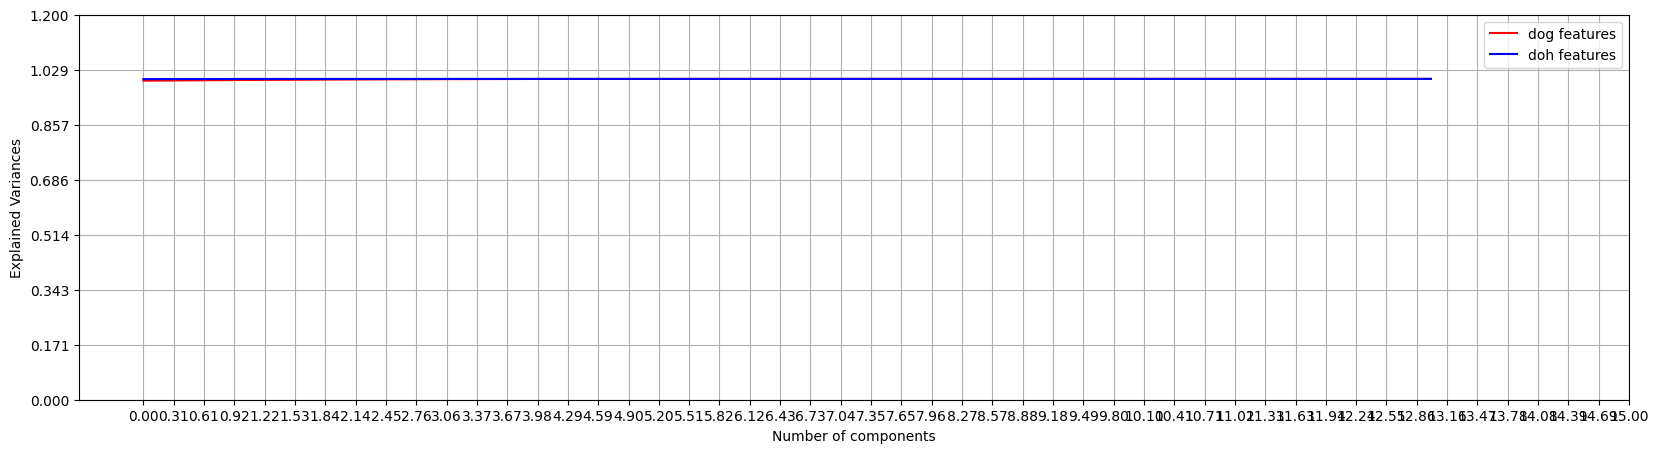

In [54]:
x = plot_PCA([X_train_dog_features[:,1:], X_train_doh_features[:,1:]], n_components=[min(X_train_dog_features[:,1:].shape), min(X_train_doh_features[:,1:].shape)])

In [39]:
X_train_dog_tsne, X_train_doh_tsne = get_tsne([X_train_dog_features[:,1:], X_train_doh_features[:,1:]], n_components=3)
le = LabelEncoder()
le.fit(Y_train)
y = le.transform(Y_train)

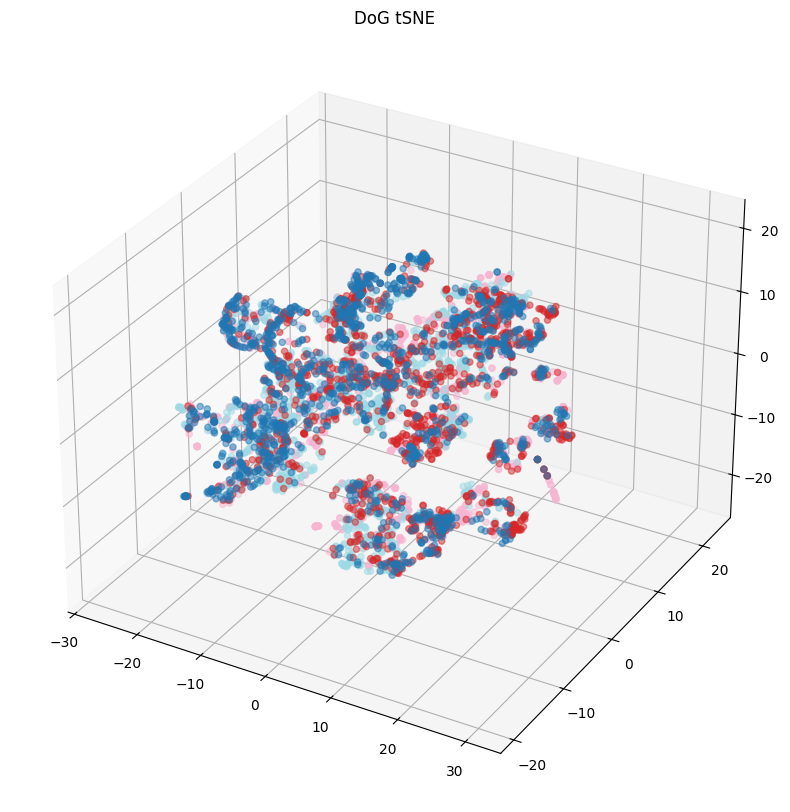

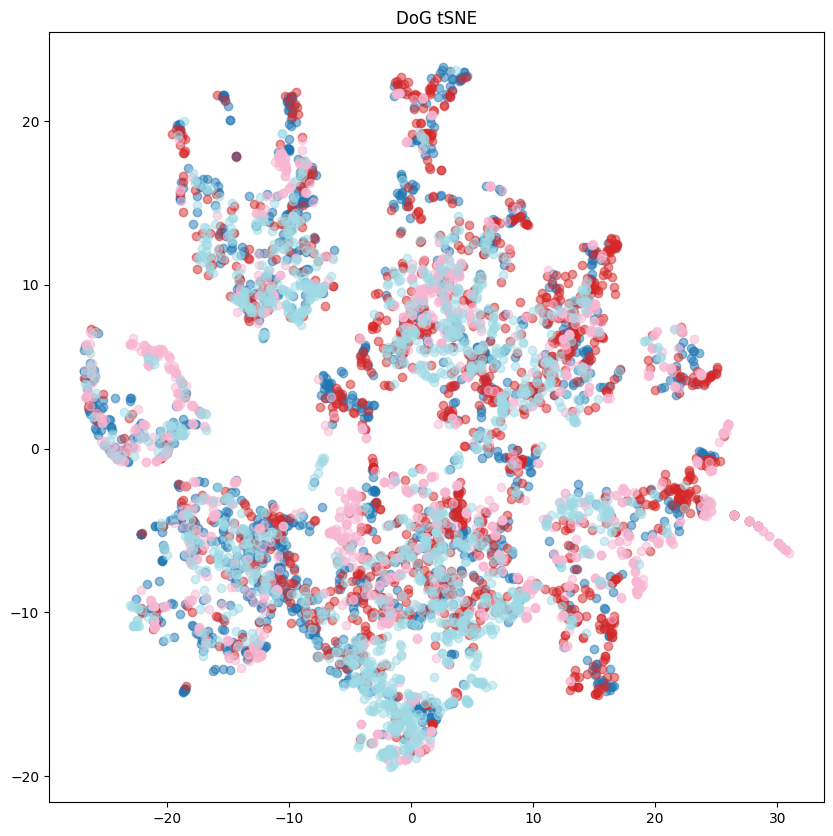

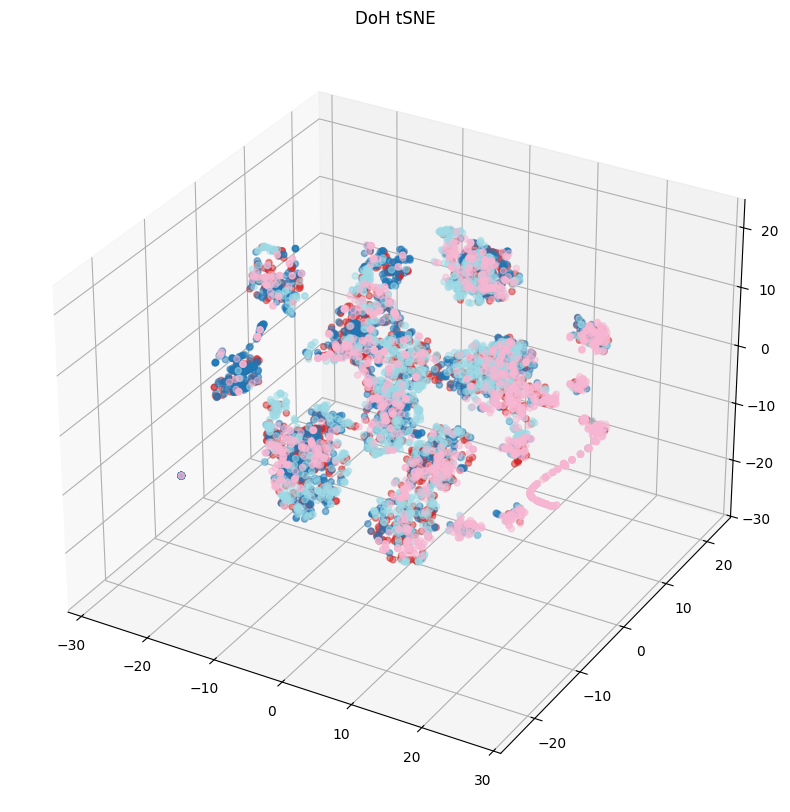

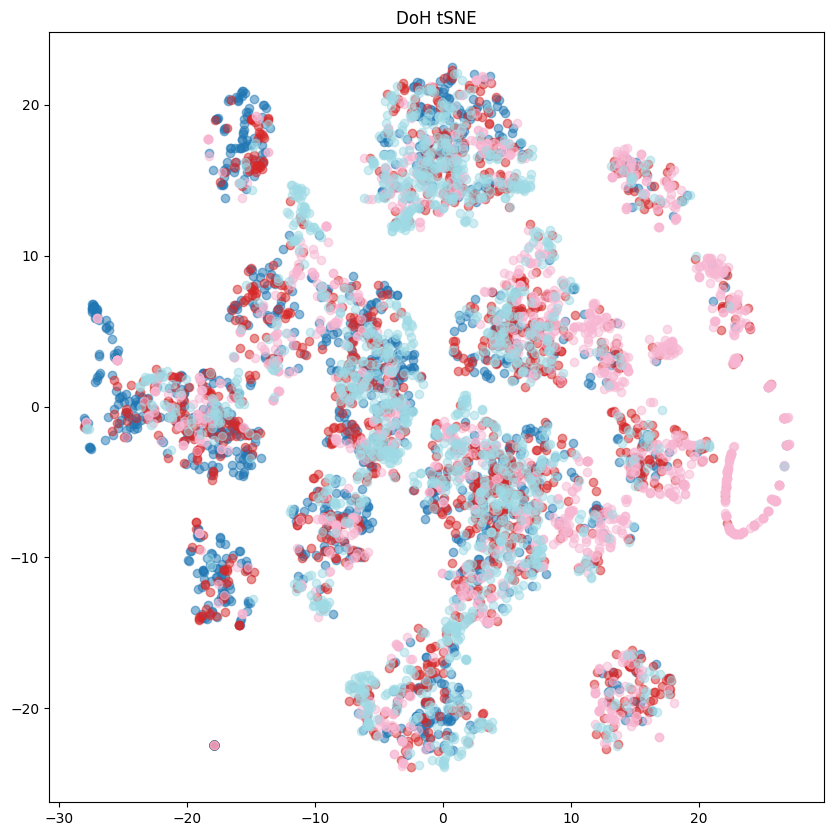

In [49]:
# plot results
plot_classes(X_train_dog_tsne, y, title='DoG tSNE')
plot_classes(X_train_dog_tsne[:,:2], y, title='DoG tSNE')
plot_classes(X_train_doh_tsne, y, title='DoH tSNE')
plot_classes(X_train_doh_tsne[:,:2], y, title='DoH tSNE')